Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Mohamed Abdelaziz | 12137202 | 10.06.2022, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 5 – Language Modeling with LSTM (Assignment)</h2>

<b>Authors:</b> N. Rekabsaz, B. Schäfl, S. Lehner, J. Brandstetter, E. Kobler<br>
<b>Date:</b> 11-05-2022

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
<p><p>This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u5_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u5_utils.py</code> need to be installed.</p></p>

In [2]:
import u5_utils as u5

import numpy as np
import torch
import os
import time
import math
# import ipdb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u5.setup_jupyter()

# Check minimum versions.
u5.check_module_versions()

Installed Python version: 3.10 (✓)
Installed numpy version: 1.24.1 (✓)
Installed pandas version: 1.5.2 (✓)
Installed PyTorch version: 1.13.1+cu116 (✓)


<h2>Language Model Training and Evaluation</h2>

<h3 style="color:rgb(0,120,170)">Data & Dictionary Preperation</h3>

<div class="alert alert-warning">
    <b>Exercise 1. [20 Points]</b>
        <ul>
            <li>Setup the data set using the same parameter settings as in the main exercise notebook.</li>
            <li>Change the batch size in the initial parameters to 64 and observe its effect on the created batches. Explain how the corpora are transformed into batches.</li>
            <li>For a specific sequence in <code>train_data_splits</code> (e.g. 5), print the corresponding words of its first 20 wordIDs.</li>
        </ul>
</div>

In [3]:
data_path = os.path.join("resources", "penn")
save_path = 'model.pt'

batch_size = 64
max_seq_len = 40

seed = 1111
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_corpus = u5.Corpus(os.path.join(data_path, 'train.txt'))
valid_corpus = u5.Corpus(os.path.join(data_path, 'valid.txt'))
test_corpus = u5.Corpus(os.path.join(data_path, 'test.txt'))

dictionary = u5.Dictionary()
train_corpus.fill_dictionary(dictionary)
ntokens = len(dictionary)

In [5]:
train_data = train_corpus.words_to_ids(dictionary)
valid_data = valid_corpus.words_to_ids(dictionary)
test_data = test_corpus.words_to_ids(dictionary)

train_data_splits = u5.batchify(train_data, batch_size, device)
val_data_splits = u5.batchify(valid_data, batch_size, device)
test_data_splits = u5.batchify(test_data, batch_size, device)

In [6]:
' '.join([dictionary.idx2word[i] for i in train_data_splits[10].tolist()[:20]])

'ipo with the exemption another latest would compromise <eos> new gas miniscribe many no concern world <unk> that thousands indian'

In [7]:
# - The Corpus Class first read the document(s) and replace the "end of line" with a "<eos>".
# - It then collects every [unique] word in the document and adds it to a dictionary as a key with a corresponding number as value.

<div class="alert alert-warning">
    <b>Exercise 2. [20 Points]</b>
        <ul>
            <li>Copy the implementation of <code>LM_LSTMModel</code> from the main exercise notebook.</li>
            <li>Add a new bool parameter to <code>LM_LSTMModel</code>'s initialization, called <code>tie_weights</code> with default value set to <code>False</code>. Extend the implementation of <code>LM_LSTMModel</code> such that if <code>tie_weights</code> is set to <code>True</code>, the model ties/shares the parameters of <code>encoder</code> with the ones of <code>decoder</code>. Consider that <code>encoder</code> and <code>decoder</code> still remain separate components but their parameters are now the same (shared). This process is called <i>weight tying</i>. Feel free to search the internet for relevant resources and implementation hints.</li>
            <li>Create two models: one with and the other without weight tying. Compare the number of parameters of the models using the same settings and report your observations.</li>
        </ul>
</div>

In [8]:
class LM_LSTMModel(torch.nn.Module):

    def __init__(self, ntoken, ninp, nhid, tie_weights=False):
        super(LM_LSTMModel, self).__init__()
        self.tie_weights = tie_weights
        self.ntoken = ntoken
        self.encoder = torch.nn.Embedding(ntoken, ninp) # matrix E in the figure
        self.rnn = torch.nn.LSTM(ninp, nhid)
        self.decoder = torch.nn.Linear(nhid, ntoken) # matrix U in the figure

        if tie_weights:
            if ninp != nhid:
                raise ValueError('Number of inputs should equal to number of hiddens')
            self.decoder.weight = self.encoder.weight
            
        self.init_weights()
        self.nhid = nhid

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

        
    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(1, bsz, self.nhid),
                weight.new_zeros(1, bsz, self.nhid))

    def forward(self, input, hidden, return_logs=True):

        emb = self.encoder(input)
        hiddens, last_hidden = self.rnn(emb, hidden)
        
        decoded = self.decoder(hiddens)

        if return_logs:
            y_hat = torch.nn.LogSoftmax(dim=-1)(decoded)
        else:
            y_hat = torch.nn.Softmax(dim=-1)(decoded)
#         ipdb.set_trace()

        return y_hat, last_hidden

In [9]:
emsize = 400
nhid = 400

untied = LM_LSTMModel(ntokens, emsize, nhid)
untied.to(device)

print(f'Untied Model: {untied}')
print(f'\t\tModel total parameters: {sum(p.numel() for p in untied.parameters())}')
print(f'\t\tModel total trainable parameters: {sum(p.numel() for p in untied.parameters() if p.requires_grad)}\n\n')

tied = LM_LSTMModel(ntokens, emsize, nhid, tie_weights=True)
tied.to(device)

print(f'Tied Model: {tied}')
print(f'\t\tModel total parameters: {sum(p.numel() for p in tied.parameters())}')
print(f'\t\tModel total trainable parameters: {sum(p.numel() for p in tied.parameters() if p.requires_grad)}')

Untied Model: LM_LSTMModel(
  (encoder): Embedding(10001, 400)
  (rnn): LSTM(400, 400)
  (decoder): Linear(in_features=400, out_features=10001, bias=True)
)
		Model total parameters: 9294001
		Model total trainable parameters: 9294001


Tied Model: LM_LSTMModel(
  (encoder): Embedding(10001, 400)
  (rnn): LSTM(400, 400)
  (decoder): Linear(in_features=400, out_features=10001, bias=True)
)
		Model total parameters: 5293601
		Model total trainable parameters: 5293601


In [10]:
# The Un-Tied Model has a total parameters of around 9.3 million while the Tied Model has a total parameters of 5.3 Million
# This is due to the fact that in the tied model, the decoder reuses the parameters of the encoder instead of creating a new
# matrix, which decreases the number of the parameters drastically, but imposes some resterictions as the embedding size should
# equal to the number of hiddens "for the matrix multiplication to be valid".

# This is argued to improve the output of the language models while maintaining lower number of parameters "more memory effecient"
# But this wouldn't affect the training "time" as it will have to update "the gradients" for the decoder but using the shared
# parameters

# According to:
# https://arxiv.org/abs/1608.05859v3

<h3 style="color:rgb(0,120,170)">Training and Evaluation</h3>


<div class="alert alert-warning">
    <b>Exercise 3. [30 Points]</b>
        <ul>
            <li>Train a model with and without weight tying for at least $10$ epochs.
            <li>Using <code>ipdb</code>, look inside the <code>forward</code> function of <code>LM_LSTMModel</code> during training. Check the forward process from input to output particularly by looking at the shapes of tensors. Report the shape of all tensors used in <code>forward</code>. Try to translate the numbers into batches $B$ and sequence length $L$. For instance, if we know that the batch size is $B=32$, a tensor of shape $(32, 128, 3)$ can be interpreted as a batch of $32$ sequences with $3$ channels of size $L=128$. Thus, this tensor can be translated into $(32, 128, 3) \rightarrow (B, L, 3)$.
            Look at the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM">official documentation</a> to understand the order of the dimensions.
            </li>
            <li>Evaluate the models. Compare the performances of both models (with and without weight tying) on train, validation and test set, and report your observations. To do so, create a plot displaying the following curves:
            <ul>
            <li>loss on each current training batch before every model update step as function of epochs</li>
            <li>loss on the validation set at every epoch</li>
            </ul>
            In addition, include corresponding <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.semilogy.html">semilogy</a> plots of the perplexity.</li>
        </ul>
</div>

In [11]:
CUT_AFTER_BATCHES = -1
epochs = 1
print_interval = 363


def train(model: torch.nn.Module, optimizer: torch.optim.Optimizer, dictionary: u5.Dictionary,
          max_seq_len: int, train_batch_size: int, train_data_splits,
          clipping: float, learning_rate: float, print_interval: int, epoch: int):
    """
    Train the model. Training mode turned on to enable dropout.
    """
    model.train()
    total_loss = 0.0
    start_time = time.time()
    ntokens = len(dictionary)
    start_hidden = model.init_hidden(train_batch_size)
    
    for batch_i, i in enumerate(range(0, train_data_splits.size(0) - 1, max_seq_len)):
        batch_data, batch_targets = u5.get_batch(train_data_splits, i, max_seq_len)
        # ipdb.set_trace()

        optimizer.zero_grad()
        
        start_hidden = u5.repackage_hidden(start_hidden)
        
        y_hat_logprobs, last_hidden = model(batch_data, start_hidden, return_logs=True)
        
        y_hat_logprobs = y_hat_logprobs.view(-1, ntokens)
        loss = torch.nn.NLLLoss()(y_hat_logprobs, batch_targets.view(-1))
        loss.backward()

        start_hidden = last_hidden

        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping)
        
        optimizer.step()
        
        total_loss += loss.item()

        if batch_i % print_interval == 0 and batch_i > 0:
            cur_loss = total_loss / print_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | perplexity {:8.2f}'.format(
                epoch, batch_i, (train_data_splits.size(0) - 1) // max_seq_len, learning_rate,
                              elapsed * 1000 / print_interval, cur_loss, math.exp(cur_loss)))
            train_loss = total_loss
            total_loss = 0
            start_time = time.time()

        if (CUT_AFTER_BATCHES != -1) and (batch_i >= CUT_AFTER_BATCHES):
            print("WARNING: Training is interrupted after %d batches" % batch_i)
            break
    return train_loss

In [12]:
# Untied Model
torch.manual_seed(seed)

lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(untied.parameters(), lr=lr, momentum=0.9)

untied_trn_losses = []
untied_val_losses = []
best_val_loss = None

# Loop over epochs.
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_loss = train(untied, optimizer, dictionary, max_seq_len, batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u5.evaluate(untied, dictionary, max_seq_len, batch_size, val_data_splits, torch.nn.NLLLoss())
    
    untied_trn_losses.append(train_loss)
    untied_val_losses.append(val_loss)
    
    print('-' * 89)
    print(f'| end of epoch {epoch :3d} | time: {time.time() - epoch_start_time :5.2f}s' 
          f'| valid loss {val_loss :5.2f} | valid perplexity {math.exp(val_loss):8.2f}')
    print('-' * 89)
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, 'wb') as f:
            torch.save(untied, f)
        best_val_loss = val_loss
    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g['lr'] = lr

| epoch   0 |   363/  363 batches | lr 20.00 | ms/batch 28.78 | loss  5.87 | perplexity   355.35
-----------------------------------------------------------------------------------------
| end of epoch   0 | time: 10.70s| valid loss  5.41 | valid perplexity   222.54
-----------------------------------------------------------------------------------------


In [13]:
# ipdb> input.shape
# torch.Size([40, 64])
# ipdb> hiddens.shape
# torch.Size([40, 64, 400])
# ipdb> decoded.shape
# torch.Size([40, 64, 10001])
# ipdb> y_hat.shape
# torch.Size([40, 64, 10001])
# ipdb> exit

# Input Shape is (40, 64) -> (Sequence Length, Batch Size)
# Hiddens Shape is (40, 64, 400) -> (Sequence Length * 1 "Not BiDirectional", Batch Size, Hidden Size)
# Output Shape is (40, 64, 10001) -> (Sequence Length * 1, Batch Size, Number of Tokens "Number of unique words in the dict")

In [14]:
# Tied Model
torch.manual_seed(seed)

lr = 20  # initial learning rate
clipping = 0.25  # gradient clipping
optimizer = torch.optim.SGD(tied.parameters(), lr=lr, momentum=0.9)

tied_trn_losses = []
tied_val_losses = []
best_val_loss = None

# Loop over epochs.
for epoch in range(epochs):
    epoch_start_time = time.time()
    train_loss = train(tied, optimizer, dictionary, max_seq_len, batch_size, train_data_splits, clipping, lr, print_interval, epoch)
    val_loss = u5.evaluate(tied, dictionary, max_seq_len, batch_size, val_data_splits, torch.nn.NLLLoss())
    
    tied_trn_losses.append(train_loss)
    tied_val_losses.append(val_loss)
    print('-' * 89)
    print(f'| end of epoch {epoch :3d} | time: {time.time() - epoch_start_time :5.2f}s' 
          f'| valid loss {val_loss :5.2f} | valid perplexity {math.exp(val_loss):8.2f}')
    print('-' * 89)
    
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open(save_path, 'wb') as f:
            torch.save(tied, f)
        best_val_loss = val_loss
    else:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
        lr /= 4.0
        for g in optimizer.param_groups:
            g['lr'] = lr

| epoch   0 |   363/  363 batches | lr 20.00 | ms/batch 24.78 | loss  5.80 | perplexity   331.35
-----------------------------------------------------------------------------------------
| end of epoch   0 | time:  9.23s| valid loss  5.42 | valid perplexity   226.15
-----------------------------------------------------------------------------------------


In [15]:
# ipdb> input.shape
# torch.Size([40, 64])
# ipdb> hiddens.shape
# torch.Size([40, 64, 400])
# ipdb> decoded.shape
# torch.Size([40, 64, 10001])
# ipdb> y_hat.shape
# torch.Size([40, 64, 10001])
# ipdb> exit

# Input Shape is (40, 64) -> (Sequence Length, Batch Size)
# Hiddens Shape is (40, 64, 400) -> (Sequence Length * 1 "Not BiDirectional", Batch Size, Hidden Size)
# Output Shape is (40, 64, 10001) -> (Sequence Length * 1, Batch Size, Number of Tokens "Number of unique words in the dict")

Untied
	Test Loss:		5.372311121197548
	Test Perplexity:		  215.36

Tied
	Test Loss:		5.375822997204438
	Test Perplexity:		  216.12




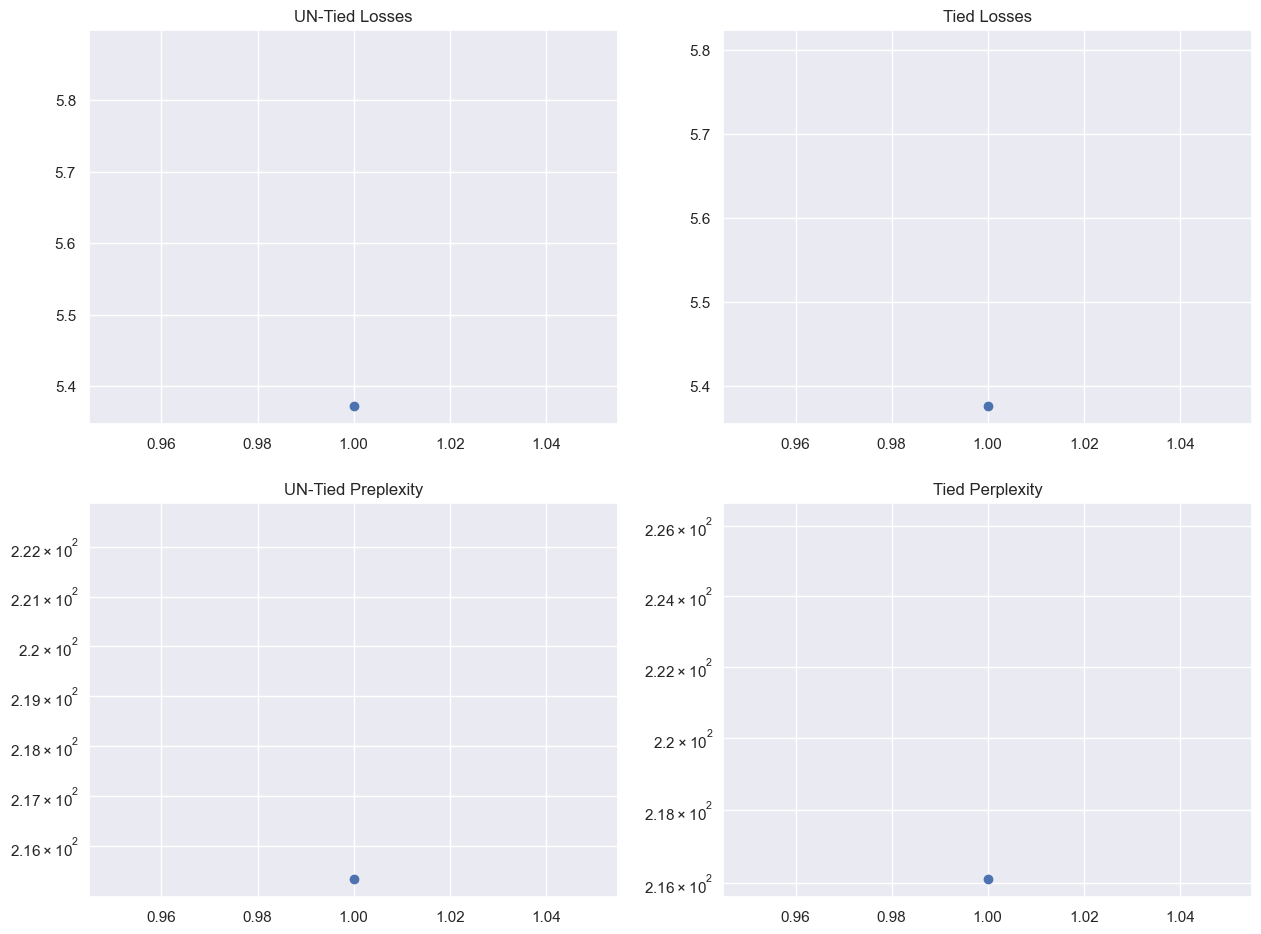

In [16]:
untied_curves = {'training': np.asarray(untied_trn_losses)}
untied_curves['validation'] = np.asarray(untied_val_losses)
untied_df = pd.DataFrame(untied_curves, index=np.arange(1, epochs + 1))
untied_test_eval = u5.evaluate(untied, dictionary, max_seq_len, batch_size, test_data_splits, torch.nn.NLLLoss())
untied_perplexity = untied_df.apply(np.exp)
print(f'Untied\n\tTest Loss:\t\t{untied_test_eval}\n\tTest Perplexity:\t\t{math.exp(untied_test_eval):8.2f}\n')

tied_curves = {'training': np.asarray(tied_trn_losses)}
tied_curves['validation'] = np.asarray(tied_val_losses)
tied_df = pd.DataFrame(tied_curves, index=np.arange(1, epochs + 1))
tied_test_eval = u5.evaluate(tied, dictionary, max_seq_len, batch_size, test_data_splits, torch.nn.NLLLoss())
tied_perplexity = tied_df.apply(np.exp)
print(f'Tied\n\tTest Loss:\t\t{tied_test_eval}\n\tTest Perplexity:\t\t{math.exp(tied_test_eval):8.2f}\n\n')


fig = plt.figure(figsize=(15,3))
fig.subplots_adjust(top=3)

ax1 = fig.add_subplot(221)
ax1.set_title('UN-Tied Losses')
untied_df['training'] = untied_df['training'] / 363
line1 = ax1.plot(untied_df)
point1 = ax1.scatter(len(untied_trn_losses), [untied_test_eval])

ax2 = fig.add_subplot(222)
ax2.set_title('Tied Losses')
tied_df['training'] = tied_df['training'] / 363
line2 = ax2.plot(tied_df)
point2 = ax2.scatter(len(tied_trn_losses), [tied_test_eval])

ax3 = fig.add_subplot(223)
ax3.grid(True, which ="both")
ax3.set_title('UN-Tied Preplexity')
ax3.semilogy(untied_perplexity)
point3 = ax3.scatter(len(untied_trn_losses), [math.exp(untied_test_eval)])

ax4 = fig.add_subplot(224)
ax4.grid(True, which ="both")
ax4.set_title('Tied Perplexity')
ax4.semilogy(tied_perplexity)
point4 = ax4.scatter(len(tied_trn_losses), [math.exp(tied_test_eval)])

plt.show()

In [17]:
# Both Models Seems to converge very similarly with the fact that Tied-Weights Model consume half the memory of the UnTied Weights
# Model, Also The Tied model seems to out-perform the Untied model with a small margin "Was Tested on different hidden/input sizes"
# But Both Models seems to spend almost the same amount of time during training, thus its not an actual speed-up.
# As for the Over-fitting problem, Both models seem to suffer from the same problem but the Tied-Model "On Different sizes"
# Sometimes slightly help in overcomming this problem "With an Early Stopping in place".

<h2>Language Generation</h2>

<div class="alert alert-warning">
    <b>Exercise 4. [30 Points]</b>
    <p>
    Copy the language generation code from the main exercise notebook and perform the following tasks:
    </p>
        <ul>
            <li>Compare both previous models by generating $10$ words that append the sequence <tt>"Yesterday I"</tt>.</li>
            <li>For each model, retrieve the top-10 wordIDs with the highest probabilities from the generated probability distribution (<code>prob_dist</code>) of the last known word (i.e. <tt>"I"</tt>). Fetch the corresponding words of these wordIDs. Do you observe any specific linguistic characteristic common between these words?</li>
            <li>The implementation in the main exercise notebook is based on sampling. Implement a deterministic variant based on the top-1 approach. In this particular variant, the generated word is the word with the highest probability in the predicted probability distribution.</li>
        </ul>
</div>

In [18]:
def generate(untied, START_WORD="Yesterday I", GENERATION_LENGTH=10):
    GENERATION_LENGTH = 10
    START_WORD = "Yesterday I"

    start_hidden = untied.init_hidden(1)
    START_WORDS = START_WORD.lower()
    START_WORDS = START_WORDS.split(' ')[-1]

    generated_text = START_WORD

    with torch.no_grad():
        wordid_inputs = [dictionary.word2idx[x] for x in START_WORDS]
        untied_generated_words, untied_top_words = [START_WORDS],  []

        for i in range(0, GENERATION_LENGTH):
            data = u5.batchify(torch.tensor(wordid_inputs), 1, device)
            y_hat_probs, last_hidden = untied(data, start_hidden, return_logs=False)

            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
            wordid_inputs = [torch.argmax(prob_dist.probs)]

            topk = torch.topk(prob_dist.probs, 10)[-1]
            untied_top_words.append([dictionary.idx2word[x] for x in topk])

            word_generated = dictionary.idx2word[wordid_inputs[-1]]
            untied_generated_words.append(*[dictionary.idx2word[x] for x in wordid_inputs])

            generated_text += " " + word_generated

            start_hidden = last_hidden

    untied_words_gen = pd.DataFrame(np.array(untied_generated_words), columns=['initial'])

    untied_words_gen = pd.concat([untied_words_gen, pd.DataFrame(np.array(untied_top_words))], axis=1)
    return (generated_text, untied_words_gen)

In [19]:
untied_gen, untied_top_words = generate(untied)
tied_gen, tied_top_words = generate(tied)

print(f'Untied Model produced:\t\t{untied_gen}')
print(f'Tied Model produced:\t\t{tied_gen}\n\n')

print('The Highest Probabilities by Word -UNTIED-')
print(untied_top_words, '\n\n')

print('The Highest Probabilities by Word -TIED-')
print(tied_top_words)

Untied Model produced:		Yesterday I 've been <unk> <eos> the <unk> <unk> <unk> <unk> <unk>
Tied Model produced:		Yesterday I 've been <unk> <eos> the <unk> <unk> <unk> <unk> <unk>


The Highest Probabilities by Word -UNTIED-
   initial      0      1      2      3               4      5      6  \
0        i    've     'm     do  think              'd    'll  would   
1      've   been     to   made    had           <unk>   seen    yet   
2     been  <unk>    not  going     an               a   used   more   
3    <unk>  <eos>     in   with     to             for     on    the   
4    <eos>    the     in    but      i             mr.  <unk>      a   
5      the  <unk>    new  house   u.s.  administration  white   bill   
6    <unk>  <unk>    was   will     of             are     is    has   
7    <unk>  <unk>    the     of  <eos>             and      a     in   
8    <unk>  <unk>  <eos>    the     in             and      a     to   
9    <unk>  <unk>  <eos>    the    and              in 

In [20]:
def generate_samples(untied, START_WORD="Yesterday I", GENERATION_LENGTH=10):
    GENERATION_LENGTH = 10
    START_WORD = "Yesterday I"

    start_hidden = untied.init_hidden(1)
    START_WORDS = START_WORD.lower()
    START_WORDS = START_WORDS.split(' ')[-1]

    generated_text = START_WORD

    with torch.no_grad():
        wordid_inputs = [dictionary.word2idx[x] for x in START_WORDS]
        untied_generated_words, untied_top_words = [START_WORDS],  []

        for i in range(0, GENERATION_LENGTH):
            data = u5.batchify(torch.tensor(wordid_inputs), 1, device)
            y_hat_probs, last_hidden = untied(data, start_hidden, return_logs=False)

            prob_dist = torch.distributions.Categorical(y_hat_probs.squeeze())
            wordid_inputs = [prob_dist.sample()]
            print(prob_dist)
#             wordid_inputs = [torch.argmax(prob_dist.probs)]

            topk = torch.topk(prob_dist.probs, 10)[-1]
            untied_top_words.append([dictionary.idx2word[x] for x in topk])

            word_generated = dictionary.idx2word[wordid_inputs[-1]]
            untied_generated_words.append(*[dictionary.idx2word[x] for x in wordid_inputs])

            generated_text += " " + word_generated

            start_hidden = last_hidden

    untied_words_gen = pd.DataFrame(np.array(untied_generated_words), columns=['initial'])

    untied_words_gen = pd.concat([untied_words_gen, pd.DataFrame(np.array(untied_top_words))], axis=1)
    return (generated_text, untied_words_gen)

In [21]:
untied_gen, untied_top_words = generate_samples(untied)
tied_gen, tied_top_words = generate_samples(tied)

print(f'Untied Model produced:\t\t{untied_gen}')
print(f'Tied Model produced:\t\t{tied_gen}\n\n')

print('The Highest Probabilities by Word -UNTIED-')
print(untied_top_words, '\n\n')

print('The Highest Probabilities by Word -TIED-')
print(tied_top_words)

Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Categorical(probs: torch.Size([10001]))
Untied Model produced:		Yesterday I expect brokers items <eos> indeed a <unk> side programs wertheim
Tied Model produced:		Yesterday I measures coin gotten fellow tobacco should identify any negative 

In [ ]:
# Using the High Probabily prediction generation it is clear that "both" models perform somehow good, as we consider the highest
# probability as the next word, that generates a Not-Only Grammatically "Somehow correct" but also with some context involved,
# which reflects that weight tying is a good practice in this situation, since it decreases the model size significantly, while
# yielding some better results.

# Gramatical Coherence in both models can be observed,
# For example it's normal that after "I" there generally comes a "verb Be/Can/Have" and after a "verb" usually comes a "noun" etc.
# and since the dataset is somehow biased towards the financial sector, it can be observed that the context is also influenced by
# this fact.